In [1]:
import math
import sys
import pandas as pd
import yaml
import os
import torch
import albumentations as Albus
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, notebook
from dataset import KakaoDetection
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
from torchvision.utils import draw_bounding_boxes
from torchvision.models import detection
from torch.utils.data import DataLoader


In [2]:
with open("config.yaml", "r") as f:
        config = yaml.safe_load(f)

img_size = config["IMG_SIZE"]
def get_transforms(train=False):
    if train:
        transform = Albus.Compose([
            Albus.Resize(img_size, img_size),
            Albus.HorizontalFlip(p=0.3),
            Albus.VerticalFlip(p=0.3),
            ToTensorV2()], 
            bbox_params=Albus.BboxParams(format='coco'))
    else:
        transform = Albus.Compose([
            Albus.Resize(img_size, img_size),
            ToTensorV2()], 
            bbox_params=Albus.BboxParams(format='coco'))
    return transform

In [3]:
train_dataset = KakaoDetection(root=config["ROOT_DIR"], split="train", transforms=get_transforms(True))
test_dataset = KakaoDetection(root=config["ROOT_DIR"], split="test", transforms=get_transforms(False))

def collate_fn(batch):
    return tuple(zip(*batch))

train_load = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_load = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
coco = COCO(os.path.join(config["ROOT_DIR"], "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


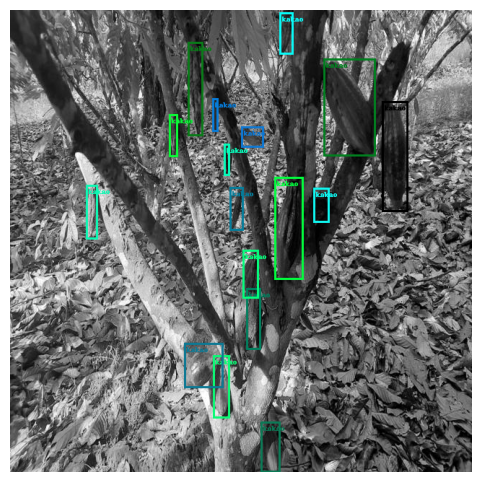

In [5]:
img, target = test_dataset[0]
img_int = (img * 255).type(torch.uint8)

plt.figure(figsize=(6,6))
plt.imshow(draw_bounding_boxes(img_int, 
                               target['boxes'], 
                               [classes[i] for i in target['labels']], width=3).permute(1,2,0))

plt.axis("off")
plt.show()

In [6]:
# define model
model = detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [7]:
# define device to use
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

# get sample image from test data
images, targets = next(iter(test_load))
images = list(image.to(device) for image in images)
targets = [{k:v.to(device) for k, v in t.items()} for t in targets]

#set model to evaluation mode
model = model.to(device)
model.eval()

# do some detections
outputs = model(images)

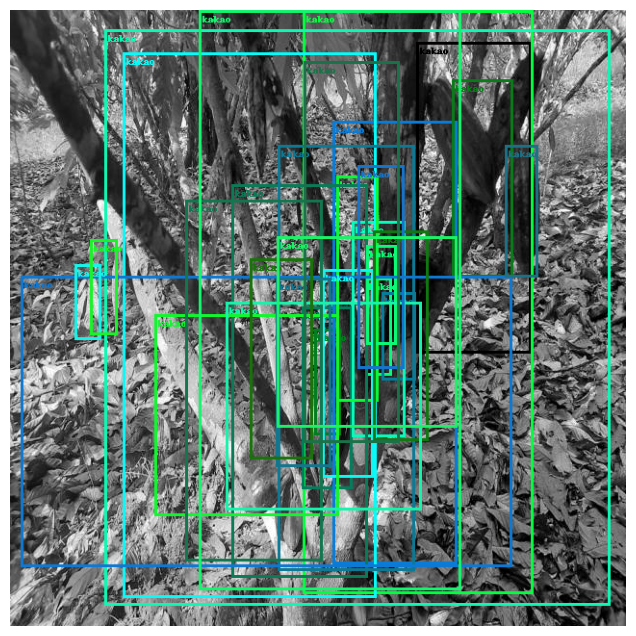

In [8]:
# plot predicted box
img_int = (images[0] * 255).type(torch.uint8)
preds = outputs[0]
threshold = 0.6
predicts = preds['boxes'][preds['scores'] > threshold]
pr_labels = [classes[i] for i in preds['labels'][preds['scores'] > threshold].tolist()]

plt.figure(figsize=(8,8))
plt.imshow(draw_bounding_boxes(img_int, predicts,pr_labels, width=3).permute(1,2,0))
plt.axis("off")
plt.show()

In [23]:
# implement training code
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [24]:
# training for one epoch
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
   
    all_losses = []
    all_losses_dict = []
    for images, targets in notebook.tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k:v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        # if not math.isfinite(loss_value):
        #     print(f"Loss is {loss_value}, training stopped.") # training stop if loss = inf
        #     print(loss_dict)
        #     sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr:{:.6f}, loss:{:.6f}, loss_classifier:{:.6f}, loss_box:{:.6f}, loss_rpn_box:{:.6f}, loss_object:{:.6f}".format(
        epoch, 
        optimizer.param_groups[0]['lr'], 
        np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))


In [26]:
num_epochs=15

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_load, device, epoch)
    scheduler.step()

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 0, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.059734, loss_object:0.454272


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.059601, loss_object:0.450932


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.059311, loss_object:0.447743


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.059492, loss_object:0.445065


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.059103, loss_object:0.442137


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.059102, loss_object:0.438628


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.058902, loss_object:0.435764


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.059513, loss_object:0.433840


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.058939, loss_object:0.430619


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9, lr:0.001000, loss:nan, loss_classifier:nan, loss_box:nan, loss_rpn_box:0.058696, loss_object:0.428114


In [27]:
# implement testing code
torch.cuda.empty_cache()